In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
from datetime import datetime
import seaborn as sns
from tqdm import tqdm
import math

pd.plotting.register_matplotlib_converters()
%matplotlib inline`


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout, BatchNormalization
from keras.optimizer_v2 import adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import datasets, neighbors
from mlxtend.plotting import plot_decision_regions

print("Setup Complete")

Setup Complete


In [3]:
#df = pd.read_csv("../input/run-or-walk/dataset.csv", index_col='date', parse_dates=True)
df = pd.read_csv("dataset.csv")

df.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88588 entries, 0 to 88587
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            88588 non-null  object 
 1   time            88588 non-null  object 
 2   username        88588 non-null  object 
 3   wrist           88588 non-null  int64  
 4   activity        88588 non-null  int64  
 5   acceleration_x  88588 non-null  float64
 6   acceleration_y  88588 non-null  float64
 7   acceleration_z  88588 non-null  float64
 8   gyro_x          88588 non-null  float64
 9   gyro_y          88588 non-null  float64
 10  gyro_z          88588 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 7.4+ MB


In [5]:
df.columns

Index(['date', 'time', 'username', 'wrist', 'activity', 'acceleration_x',
       'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z'],
      dtype='object')

In [6]:
df.dtypes

date               object
time               object
username           object
wrist               int64
activity            int64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
dtype: object

In [7]:
df.isna().any()

date              False
time              False
username          False
wrist             False
activity          False
acceleration_x    False
acceleration_y    False
acceleration_z    False
gyro_x            False
gyro_y            False
gyro_z            False
dtype: bool

In [8]:
null_data = df[df.isnull().any(axis=1)]
print(len(null_data))

0


In [9]:
df['activity'].unique()

array([0, 1], dtype=int64)

In [10]:
print("Walking activity:", (df['activity'] == 0).sum(axis=0))
print("Running activity:", (df['activity'] == 1).sum(axis=0))

Walking activity: 44223
Running activity: 44365


In [11]:
cols = ['date', 'time']
df['combined'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df2 = df.drop(['username', 'date', 'time', 'wrist'], axis = 1)

In [12]:
#df['datetime'] =  pd.to_datetime(df['time'], format='%d%b%Y:%H:%M:%S.%f')
df2['datetime'] =  pd.to_datetime(df2['combined'], format='%Y-%m-%d %H:%M:%S:%f')
df3 = df2.drop('combined', axis = 1)
df3

,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,datetime
0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296,2017-06-30 13:51:15.847724020
1,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269,2017-06-30 13:51:16.246945023
2,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367,2017-06-30 13:51:16.446233987
3,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336,2017-06-30 13:51:16.646117985
4,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922,2017-06-30 13:51:16.846738994
...,...,...,...,...,...,...,...,...
88583,0,0.3084,-0.8376,-0.1327,0.4823,2.0124,0.6048,2017-07-09 20:09:15.317911028
88584,0,0.4977,-1.0027,-0.4397,0.1022,-1.2565,-0.0761,2017-07-09 20:09:15.517889022
88585,0,0.4587,-1.1780,-0.2827,-1.4500,-0.2792,-1.2616,2017-07-09 20:09:15.717828989
88586,0,0.2590,-0.8582,-0.0759,-1.5165,0.4560,-1.7755,2017-07-09 20:09:15.917932987


Can we plot the activity per day, for example the counts of 1 in a day and plot the counts as Y and days as X.

In [13]:
df_sorted = df3.sort_values('datetime').reset_index(drop=True)

In [14]:
choice = "2017-07-02"
x_day = df_sorted[df_sorted['datetime'].dt.strftime('%Y-%m-%d') == choice]
print("Total day Samples:", len(x_day))
print("Running samples:", len(x_day.loc[(x_day['activity'] == 1)]))


Total day Samples: 3933
Running samples: 3504


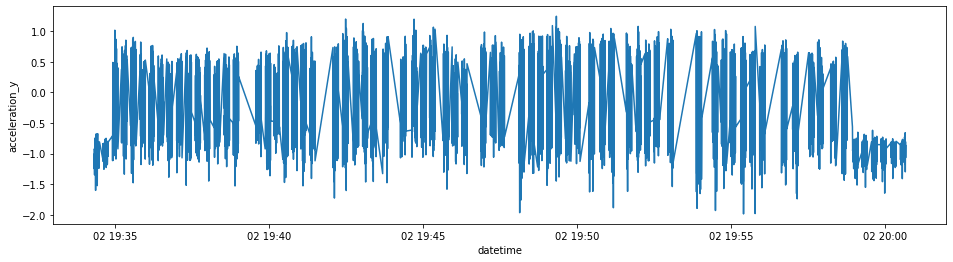

In [15]:
my_figsize = (16, 4)
plt.figure(figsize=my_figsize)

sns.lineplot(x="datetime", y="acceleration_y", data=x_day)
#sns.lineplot(x="datetime", y="acceleration_y", data=df_sorted)

#plt.title('accelerometer')
plt.show()

In [16]:
pd.concat([df_sorted.head(1), df_sorted.tail(1)])

,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,datetime
0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296,2017-06-30 13:51:15.847724020
88587,1,-2.1825,0.1876,0.0430,-2.2937,-0.6059,-0.6293,2017-07-17 20:16:03.851119750


need to plot samples per hour in a single day

In [17]:
X = df_sorted.iloc[:,1:7]
X

,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922
...,...,...,...,...,...,...
88583,-0.3145,-0.5619,0.2554,-1.4393,0.1370,-1.5961
88584,0.2041,0.4117,-0.1134,0.8280,0.8089,1.9331
88585,-2.9406,0.4090,0.0523,2.2648,0.2342,3.7748
88586,-0.0219,-0.5711,0.1658,0.2210,-1.5538,0.6392


In [18]:
ssc = StandardScaler()
X = ssc.fit_transform(X)
X

array([[ 0.33668266, -0.33231618,  0.6293112 , -0.05039065, -0.00392358,
        -1.5419494 ],
       [ 0.74013342, -0.85156246,  0.16342314, -0.14349622, -0.013684  ,
         0.05462392],
       [ 0.50997229, -1.39586742,  0.79323478, -0.72973418,  0.05764218,
        -1.28448139],
       ...,
       [-2.83940227,  1.47555388,  0.7523566 ,  1.80358291,  0.16433948,
         1.96011707],
       [ 0.05242424, -0.01293187,  0.98550605,  0.17299888, -1.32725368,
         0.32222559],
       [-2.08828236,  1.13931192,  0.73325272, -1.83327848, -0.53649241,
        -0.34037976]])

In [19]:
y = df_sorted.activity
y

0        0
1        0
2        0
3        0
4        0
        ..
88583    1
88584    1
88585    1
88586    1
88587    1
Name: activity, Length: 88588, dtype: int64

## Test Train split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=10) 

In [21]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train.shape, y_train.shape

((66441, 6), (66441,))

## Accuracy by Logistic Regression

In [22]:
logr = LogisticRegression()
logr.fit(X_train,y_train)
pred_logr = logr.predict(X_test)

pred_logr

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

In [23]:
logr_acc = accuracy_score(y_test,pred_logr)
print(logr_acc)

0.8530726509233756


[[9930 1164]
 [2090 8963]]


<AxesSubplot:>

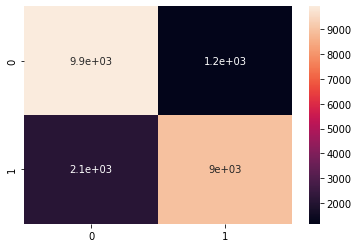

In [24]:
print(confusion_matrix(y_test,pred_logr))
#print(classification_report(y_test,pred_lr))

cm = confusion_matrix(y_test, pred_logr)

sns.heatmap(cm, annot=True)

## Accuracy by KNN

In [25]:
# instantiate the estimator
knn = KNeighborsClassifier()

# fit the model
knn.fit(X_train, y_train)

# predict the response
pred_knn = knn.predict(X_test)

# accuracy score
knn_acc = accuracy_score(y_test, pred_knn)
print ("Accuracy for KNN: {}".format(knn_acc))

Accuracy for KNN: 0.9888472479342575


In [26]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train[0:1000], y_train[0:1000])
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

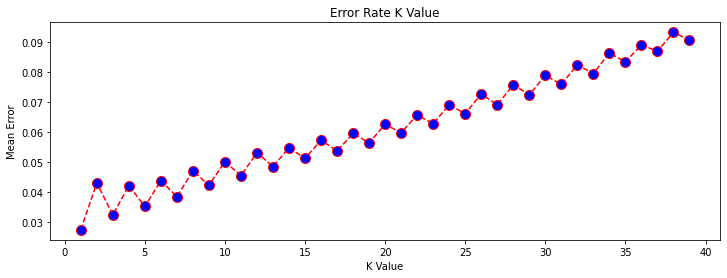

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

## Accuracy by SVM

In [28]:
# instantiate the estimator
svm = SVC()

# fit the model
svm.fit(X_train, y_train)

# predict the response
pred_svm = svm.predict(X_test)

# accuracy score
svm_acc = accuracy_score(y_test, pred_svm)
print ("Accuracy for SVM: {}".format(svm_acc))

Accuracy for SVM: 0.9870411342394003


## Accuracy by Naive Bayes

In [29]:
# instantiate the estimator
nb = GaussianNB()

# fit the model
nb.fit(X_train, y_train)

# predict the response
pred_nb = nb.predict(X_test)

# accuracy score
nb_acc = accuracy_score(y_test, pred_nb)
print ("Accuracy for Gaussian Naive Bayes: {}".format(nb_acc))

Accuracy for Gaussian Naive Bayes: 0.9581433151216869


## Accuracy by CNN model

In [30]:
model = Sequential()
model.add(Dense(250, activation = 'relu', input_shape = (6,)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 250)               1750      
                                                                 
 batch_normalization (BatchN  (None, 250)              1000      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 251       
                                                                 
Total params: 3,001
Trainable params: 2,501
Non-trainable params: 500
_________________________________________________________________


In [31]:
model.compile(loss = 'binary_crossentropy', optimizer = 'ADAM', metrics = ['accuracy'])

In [32]:
checkpoint = ModelCheckpoint("walk_run.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=7, 
                      verbose=1, 
                      mode='auto')

After several iterations of batch size and epoch tweaks, it seems that batch set to 1000 and dropout set to 25% seems to yield highest accuracy.

In [33]:
history = model.fit(X_train, y_train, 
          batch_size = 1000, 
          epochs = 50, 
          validation_split = 0.2,
          callbacks=[checkpoint,early],
          verbose = 2)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.59583, saving model to walk_run.h5
54/54 - 1s - loss: 0.3059 - accuracy: 0.8672 - val_loss: 0.5177 - val_accuracy: 0.5958 - 1s/epoch - 20ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.59583 to 0.67951, saving model to walk_run.h5
54/54 - 0s - loss: 0.1117 - accuracy: 0.9645 - val_loss: 0.4534 - val_accuracy: 0.6795 - 277ms/epoch - 5ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.67951 to 0.79795, saving model to walk_run.h5
54/54 - 0s - loss: 0.0854 - accuracy: 0.9722 - val_loss: 0.3790 - val_accuracy: 0.7980 - 245ms/epoch - 5ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.79795 to 0.89691, saving model to walk_run.h5
54/54 - 0s - loss: 0.0711 - accuracy: 0.9777 - val_loss: 0.2993 - val_accuracy: 0.8969 - 269ms/epoch - 5ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.89691 to 0.95402, saving model to walk_run.h5
54/54 - 0s - loss: 0.0636 - accuracy: 0.9795 - val_loss: 0.2157 - val_accurac

In [34]:
print("Evaluate model on test data")

results = model.evaluate(X_test, y_test, batch_size=1000)

print("test loss, test acc:", results)

# Generate a prediction using model.predict() 
# and calculate it's shape:

print("Generate a prediction")

prediction = model.predict(X_test[:1])

print("prediction shape:", prediction.shape)

Evaluate model on test data
23/23 [==============================] - 0s 2ms/step - loss: 0.0362 - accuracy: 0.9881
test loss, test acc: [0.03620617464184761, 0.9880796670913696]
Generate a prediction
prediction shape: (1, 1)


Best model accuracy sliced by the row with lowest loss

In [35]:
best_model_acc = history.history['accuracy'][np.argmin(history.history['loss'])]
cnn_acc = best_model_acc

print ("Accuracy for CNN: {}".format(cnn_acc))


Accuracy for CNN: 0.9871312379837036


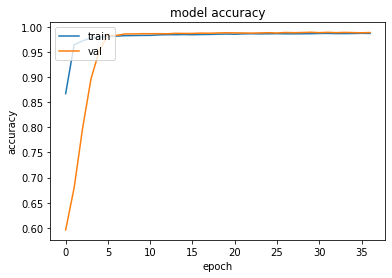

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

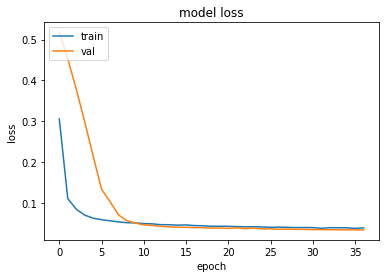

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, np.rint(y_pred))
cm

array([[10984,   110],
       [  154, 10899]], dtype=int64)

In [39]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[10984   110]
 [  154 10899]]


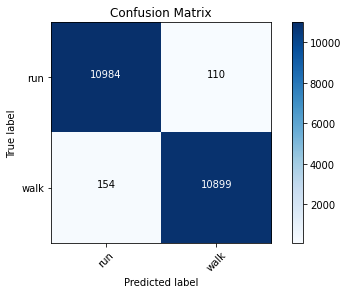

In [40]:
cm_plot_labels = ['run','walk']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


In [41]:
models = pd.DataFrame([logr_acc,svm_acc,knn_acc,nb_acc,cnn_acc],
             index=['Logistic Regression','SVM','KNN','Naive Bayes','CNN'],columns=['accuracy'])

models.sort_values('accuracy', ascending=False)

,accuracy
KNN,0.988847
CNN,0.987131
SVM,0.987041
Naive Bayes,0.958143
Logistic Regression,0.853073


In [42]:
models.accuracy.sort_values(ascending=False).values

array([0.98884725, 0.98713124, 0.98704113, 0.95814332, 0.85307265])

<AxesSubplot:>

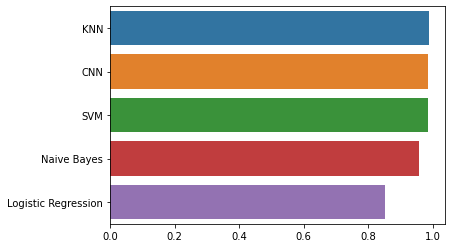

In [43]:
sns.barplot(x = models.accuracy.sort_values(ascending=False).values, 
            y = models.accuracy.sort_values(ascending=False).index)
